<a href="https://colab.research.google.com/github/smalaboy/EEG-epileptic-spikes-detection/blob/main/Experimentation%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting up environment

In [ ]:
!pip install pyts

     |████████████████████████████████| 2.5 MB 5.2 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
positive_shape = [400, 5 * 768]  # Shape of the data to read for multivariate classifier
negative_shape = [2000, 5 * 768]
testing_shape = [1200, 5 * 768]

In [ ]:
# Reading the data into numpy arrays
positive_series = np.fromfile('/content/drive/MyDrive/datasets/exp1-train-400pos.bin', dtype=np.float32).reshape(positive_shape)
positive_series2 = np.fromfile('/content/drive/MyDrive/datasets/exp2-train-400pos.bin', dtype=np.float32).reshape(positive_shape)
negative_series = np.fromfile('/content/drive/MyDrive/datasets/exp1-train-2000neg.bin', dtype=np.float32).reshape(negative_shape)
negative_series2 = np.fromfile('/content/drive/MyDrive/datasets/exp2-train-2000neg.bin', dtype=np.float32).reshape(negative_shape)

In [ ]:
# Concatenating and splitting for training and testing
p_train = np.concatenate((positive_series[:350], positive_series2[:350] ))
p_test = np.concatenate((positive_series[350:], positive_series2[350:]))
n_train = np.concatenate((negative_series[:1750], negative_series2[:1750]))
n_test = np.concatenate((negative_series[1750:], negative_series2[1750:]))

In [ ]:
X_train = np.concatenate((p_train, n_train))
# X_train = [[(row - row.min()) / (row.max() - row.min()) for row in rowset] for rowset in X_train]
X_test = np.concatenate((p_test, n_test))
# X_test = [[(row - row.min()) / (row.max() - row.min()) for row in rowset] for rowset in X_test]

In [ ]:
y_train = np.concatenate((np.ones((700,)), np.zeros((3500,))))
y_test = np.concatenate((np.ones((100,)), np.zeros((500,))))
print(y_train.shape, y_test.shape)

(4200,) (600,)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(y_true, y_pred, labels=[], classes=[]):
    """
    Confusion matrix
    """
    matrix = confusion_matrix(y_true, y_pred, labels=labels)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure()

    cmap=plt.cm.Reds

    print(matrix)

    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # fmt = '.2f'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.savefig("confusion_matrix.png")
    plt.show()

In [ ]:
import datetime
from pyts.classification import KNeighborsClassifier, TimeSeriesForest, BOSSVS, SAXVSM, TSBF
t = datetime.datetime.now()
# clf = KNeighborsClassifier(n_neighbors=5)

clf = TimeSeriesForest(n_estimators=500, n_windows=1.0)

# clf = SAXVSM(window_size=64, word_size=12, n_bins=5, strategy='normal')

# clf = TSBF(random_state=43)
clf.fit(X_train, y_train)

print("The trainig time is", (datetime.datetime.now() - t))

The trainig time is 0:05:16.831246


In [ ]:
clf.score(X_test, y_test)

0.9466666666666667

Prediction time is = 0:00:16.758395
[[0.994 0.006]
 [0.29  0.71 ]]


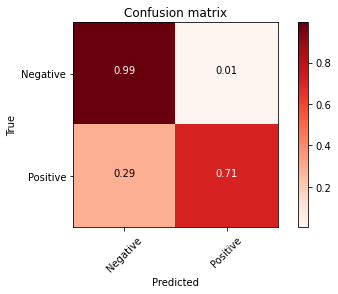

In [ ]:
t = datetime.datetime.now()
predicted = clf.predict(X_test)
print("Prediction time is =", (datetime.datetime.now() - t))
show_confusion_matrix(y_test, predicted, labels=[0, 1], classes=['Negative', "Positive"])

In [ ]:
# predicted

In [ ]:
import sklearn
print(sklearn.metrics.classification_report(y_test, predicted, target_names=['Negative', "Positive"]))

              precision    recall  f1-score   support

    Negative       0.94      0.99      0.97       500
    Positive       0.96      0.71      0.82       100

    accuracy                           0.95       600
   macro avg       0.95      0.85      0.89       600
weighted avg       0.95      0.95      0.94       600



**Test with multivariate classifier**

In [ ]:
from pyts.classification import BOSSVS, TimeSeriesForest
from pyts.datasets import load_basic_motions
from pyts.multivariate.classification import MultivariateClassifier
# X_train_, X_test_, y_train_, y_test_ = load_basic_motions(return_X_y=True)
# print(X_train_[0].shape)
# print(y_train_.shape)
m_clf = MultivariateClassifier(TimeSeriesForest(n_estimators=384))
# m_clf = MultivariateClassifier(KNeighborsClassifier(n_neighbors=5))
_X_train = X_train.reshape([4200, 5, 768])
_X_test = X_test.reshape([600, 5, 768])
m_clf.fit(_X_train, y_train)
m_clf.score(_X_test, y_test)

0.93

Prediction time is = 0:00:04.318581
              precision    recall  f1-score   support

    Negative       0.93      0.99      0.96       500
    Positive       0.95      0.61      0.74       100

    accuracy                           0.93       600
   macro avg       0.94      0.80      0.85       600
weighted avg       0.93      0.93      0.92       600

[[0.994 0.006]
 [0.39  0.61 ]]


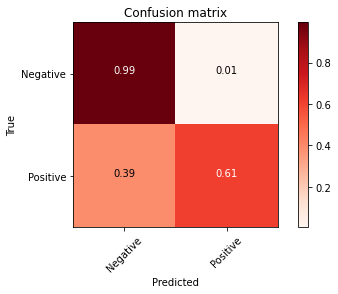

In [ ]:
import sklearn
t = datetime.datetime.now()
m_predicted = m_clf.predict(_X_test)
print("Prediction time is =", (datetime.datetime.now() - t))
print(sklearn.metrics.classification_report(y_test, m_predicted, target_names=['Negative', "Positive"]))
show_confusion_matrix(y_test, m_predicted, labels=[0, 1], classes=['Negative', "Positive"])

**Testing part**

In [ ]:
positive_series = np.fromfile('/content/drive/MyDrive/datasets/exp1-train-400pos.bin', dtype=np.float32).reshape(positive_shape)
positive_series2 = np.fromfile('/content/drive/MyDrive/datasets/exp2-train-400pos.bin', dtype=np.float32).reshape(positive_shape)
negative_series = np.fromfile('/content/drive/MyDrive/datasets/exp1-train-2000neg.bin', dtype=np.float32).reshape(negative_shape)
negative_series2 = np.fromfile('/content/drive/MyDrive/datasets/exp2-train-2000neg.bin', dtype=np.float32).reshape(negative_shape)

In [ ]:
X = np.concatenate((positive_series, positive_series2, negative_series, negative_series2))
y = np.concatenate((np.ones((800,)), np.zeros((4000,))))
X_m = X.reshape([4800, 5, 768])  # Used for multivariate classification

In [ ]:
from pyts.classification import KNeighborsClassifier, TimeSeriesForest, BOSSVS, SAXVSM, TSBF
from pyts.multivariate.classification import MultivariateClassifier
def train(X, y):
  # Next two are used for simple TimeseriesForest
  clf = TimeSeriesForest(n_estimators=500)
  clf.fit(X, y)

  # Uncomment the nex two lines for multivariate TimeseriesForest
  # clf = MultivariateClassifier(TimeSeriesForest(n_estimators=384))
  # clf.fit(X_m, y)

  return clf

In [ ]:
import datetime
t = datetime.datetime.now()
classifier = train(X, y)  # TimeseriesForest
# classifier = train(X_m, y)  # Multivariate TimeseriesForest
print("Training time is =", (datetime.datetime.now() - t))

Training time is = 0:06:13.338885


In [ ]:
test_series = np.fromfile('/content/drive/MyDrive/datasets/exp12-test-1200.bin', dtype=np.float32).reshape(testing_shape)

In [ ]:
t = datetime.datetime.now()
final_predictions = classifier.predict(test_series)
# final_predictions = classifier.predict(test_series.reshape([1200, 5, 768]) )  # Multivariate
print("Prediction time is =", (datetime.datetime.now() - t))

Prediction time is = 0:00:33.998441


**Saving to csv**

In [ ]:
import pandas as pd
data = {
    "outcome": list(map(int, final_predictions)),
    "id": list(range(1200))
    }

df = pd.DataFrame(data=data)
df

,outcome,id
0,1,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
1195,0,1195
1196,0,1196
1197,0,1197
1198,0,1198


In [ ]:
df.to_csv("csv_file.csv", index=False)